In [1]:
import os
import glob
from collections import Counter
import random
import json
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
import torch
import timm
import clip

## FACET

In [2]:
# Read FACET csv
df = pd.read_csv("../data/annotations/annotations.csv", index_col=0)
df = df.sort_values(by='filename')

unique_filenames = df['filename'].value_counts()
df = df[df['filename'].isin(unique_filenames[unique_filenames == 1].index)]
df.reset_index(inplace=True, drop=True)

# Append file paths and parse bounding box
filepaths = glob.glob("../data/imgs_*/*")
filenames = [i.split('/')[-1] for i in filepaths]
files = dict(zip(filenames, filepaths))
df['filepath'] = [files[i] for i in df['filename']]
df['bounding_box'] = df['bounding_box'].apply(json.loads)

# Drop all images with >1 person in the image
drop = []
for i in range(len(df['class2'])):
    if isinstance(df['class2'][i], str):
        drop.append(i)
df.drop(index=drop, inplace=True)
df.reset_index(inplace=True, drop=True)
df['index'] = df.index
classes = np.unique(df['class1'])

## Imagenet-21k Finetuning on FACET

In [3]:
# Load clip and preprocessor
clip_model, preprocess = clip.load("ViT-B/32", device="mps")

# Load classes labels
i21k_tree = torch.load("../data/imagenet21k_miil_tree_fall.pth", weights_only=False)
classes_im21k = list(
    i21k_tree["class_description"].values()
)
classes_facet = np.array(
    ['astronaut', 'backpacker', 'ballplayer', 'basketball_player',
    'boatman', 'carpenter', 'climber', 'computer_user', 'dancer',
    'disk_jockey', 'doctor', 'drummer', 'electrician', 'farmer',
    'fireman', 'flutist', 'gardener', 'guard', 'guitarist', 'gymnast',
    'hairdresser', 'horseman', 'laborer', 'lawman', 'lifeguard',
    'machinist', 'motorcyclist', 'nurse', 'painter', 'patient',
    'prayer', 'referee', 'repairman', 'reporter', 'retailer', 'runner',
    'sculptor', 'seller', 'singer', 'skateboarder', 'soccer_player',
    'soldier', 'speaker', 'student', 'tennis_player', 'trumpeter',
    'waiter']
)

In [4]:
# Output neurons that correspond to class labels
classes_filt = []
inds_filt = []
for i in range(len(classes_im21k)):
    if classes_im21k[i] in classes_facet:
        classes_filt.append(classes_im21k[i])
        inds_filt.append(i)
        
# Some classes have multiple output neurons
counts = Counter(classes_filt)
duplicates = [item for item, count in counts.items() if count > 1]

d = []
for k, v in i21k_tree['class_description'].items():
    if v in duplicates:
        try:
            parent = i21k_tree['class_description'][i21k_tree['child_2_parent'][k]]
        except:
            parent = i21k_tree['child_2_parent'][k]
        d.append((k, v, parent))

# Fix output neurons
selected = ['n09990415', 'n10542888', 'n10732010']
class_ids = list(i21k_tree['class_description'].keys())

classes_filt = []
inds_filt = []
for i in range(len(classes_im21k)):
    if classes_im21k[i] in classes_facet and classes_im21k[i] not in duplicates:
        classes_filt.append(classes_im21k[i])
        inds_filt.append(i)
    elif classes_im21k[i] in duplicates and classes_im21k[i] not in classes_filt:
        if class_ids[i] in selected:
            classes_filt.append(classes_im21k[i])
            inds_filt.append(
                int(np.where(np.array(class_ids) == class_ids[i])[0][0])
            )

class_lookup = {i:j for i, j in zip(classes_filt, inds_filt)}

### Train/Test Split

In [5]:
X = list(zip(list(df["filepath"]), list(df["class1"]), list(df["index"])))
X = np.array([i for i in X if i[1] in classes_facet])

df_x = pd.DataFrame(X, columns=['file', 'class', 'index'])
shuffle = StratifiedShuffleSplit(
    n_splits=1, train_size=.83, random_state=0
)
inds = list(shuffle.split(df_x, df_x['class']))[0]

X_train = X[inds[0][:16000]]
X_test = X[inds[1][:3280]]

### Train

In [6]:
def load_image(filepath, index):
    # Load
    img = Image.open(filepath)
    
    # Bounding box around target
    img = np.array(img)
    bb = df.iloc[index]['bounding_box']
    pad = 200
    j_start, i_start = int(round(bb['x'])), int(round(bb['y']))
    i_end, j_end = i_start + int(bb['height']), j_start + int(bb['width'])
    i_start, j_start = i_start-pad, j_start-pad
    i_end, j_end = i_end+pad, j_end+pad
    j_start = 0 if j_start < 0 else j_start
    i_start = 0 if i_start < 0 else i_start
    img = img[i_start:i_end+1, j_start:j_end+1]
    
    # Preprocess
    img = preprocess(Image.fromarray(img))

    return img

In [7]:
model = timm.create_model('mobilenetv3_large_100.miil_in21k', pretrained=True)
model = model.to('mps')

opt = torch.optim.Adam(model.parameters(), 1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

batch_size = 20

for i in tqdm(range(0, len(X_train), batch_size), total=len(X_train)//batch_size):

    # [image filepath, class, df index]
    xt = X_train[i:i+batch_size]

    # Load data
    x = torch.zeros((batch_size, 3, 224, 224), dtype=torch.float32)
    y = torch.zeros(batch_size, dtype=torch.int64)
    for j in range(batch_size):
        x[j] = load_image(xt[j][0], int(xt[j][2]))
        y[j] = class_lookup[xt[j][1]]
    x = x.to('mps')
    y = y.to('mps')
    
    # Forward
    y_pred = model(x)

    # Loss
    loss = loss_fn(y_pred, y)
    loss.backward()

    # Step
    opt.step()
    opt.zero_grad()

  0%|          | 0/800 [00:00<?, ?it/s]

In [9]:
torch.save(model, "model.pth")

### Test

In [7]:
# Load fine-tuned model
model = torch.load("model.pth", weights_only=False)

# Activation hook
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Stem
model.conv_stem.register_forward_hook(get_activation('conv_stem'));

# Blocks
for i_sb, sub_block in enumerate(model.blocks):
    for i_component, component in enumerate(sub_block):
        for i_layer, layer in enumerate(component.named_children()):
            if (
                'conv_pwl' in layer[0] or
                (i_sb == 6 and 'conv' in layer[0]) or
                (i_sb == 0 and 'conv_pw' in layer[0])
            ):
                name = f"block-{i_sb}_comp-{i_component}_layer-{i_layer}_{layer[0]}"
                component.get_submodule(layer[0]).register_forward_hook(
                    get_activation(name)
                )
                
# Head
model.conv_head.register_forward_hook(get_activation('conv_head'))

# Classifier
model.classifier.register_forward_hook(get_activation('classifier'));

In [14]:
# Concepts
concept_terms = [str(i) if "_" not in i else i.replace("_", " ")
                 for i in classes_facet]

concepts = clip.tokenize(classes_facet.tolist()).to("mps")

# Compute P and q_k for clip-dissect
P = np.zeros((len(X_test), len(concepts)))

n_channels = [16, 16, 24, 24, 40, 40, 40, 80, 80, 80,
              80, 112, 112, 160, 160, 160, 960, 1, 11221]
q_k = [
    np.zeros((len(X_test), i)) for i in n_channels
]   

# Only consider valid classes in the dataset
out_mask = np.array(list(class_lookup.values())).astype(int)

# Evaluate test set
y_test_true = np.zeros(len(X_test))
y_test_pred = np.zeros(len(X_test))
y_test_pred_clip = np.zeros(len(X_test))

batch_size = 20

for row in tqdm(range(0, len(X_test), batch_size), total=len(X_test)//batch_size):

    # Load data
    xt = X_test[row:row+batch_size]
    x = torch.zeros((batch_size, 3, 224, 224), dtype=torch.float32)
    y = torch.zeros(batch_size, dtype=torch.int64)
    for j in range(batch_size):
        x[j] = load_image(xt[j][0], int(xt[j][2]))
        y[j] = class_lookup[xt[j][1]]
    y_test_true[row:row+batch_size] = y.numpy()
    x = x.to('mps')
    y = y.to('mps')
    
    # Forward
    activation = {}
    y_pred = model(x)
    y_test_pred[row:row+batch_size] = np.argmax(y_pred.detach().cpu().numpy(), axis=1)
    #y_test_pred[i:i+batch_size] = np.argmax(y_pred.detach().cpu().numpy()[:, out_mask], axis=1)

    # 1. Compute P
    with torch.no_grad():
        logits_per_image, logits_per_text = clip_model(x, concepts)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    y_test_pred_clip[row:row +batch_size] = np.argmax(probs, axis=1)
    P[row:row+batch_size] = probs
    
    # 2. Compute activations, q_k)
    for i, k in enumerate(activation.keys()):
        # Activations per convolutional channel
        if k == "conv_head":
            # Last convolutional layer gets flatten
            q_k[i][row] = activation[k].cpu().numpy()[0].mean()
        elif k == 'classifier':
            q_k[i][row] = activation[k].cpu().numpy()[0]
        else:
            q_k[i][row] = activation[k].cpu().numpy()[0].mean(axis=(1, 2))

# Save results
np.save("y_test_pred", y_test_pred)
np.save("y_test_pred_clip", y_test_pred_clip)
np.save("P_terms-classes.npy", P)
for i in range(len(q_k)):
    np.save(f"qk_terms-classes_activation-{i}.npy", q_k[i])

  0%|          | 0/164 [00:00<?, ?it/s]

In [15]:
print(f"CNN accuracy: {float((y_test_pred == y_test_true).sum() / len(y_test_true))}")
class_lookup_inv = {v:k for k, v in class_lookup.items()} 
_y_test_pred = np.array([str(classes_facet[int(i)]) for i in y_test_pred_clip])
_y_test_true = np.array([class_lookup_inv[i] for i in y_test_true])
print(f"CLIP accuracy: {float((_y_test_pred == _y_test_true).sum() / len(_y_test_true))}")

CNN accuracy: 0.6125
CLIP accuracy: 0.6384146341463415


In [16]:
y_class = []
acc_clip = []
acc_conv = []
f1_clip = []
f1_conv = []

inds = []
n = 0

correct = y_test_pred == y_test_true
for i in np.unique(y_test_true):
    _inds = np.where(y_test_true == i)[0]
    inds.append(_inds)
    y_class.append(class_lookup_inv[int(i)])
    
    # Accuracy
    acc_conv.append(correct[_inds].mean())
    _y_true = np.zeros(len(y_test_true))

    _acc_clip = (_y_test_pred[_inds] == _y_test_true[_inds]).mean()
    acc_clip.append(float(_acc_clip))

    # F1
    _y_true[_inds] = 1.
    _y_pred = np.zeros(len(y_test_true))
    _y_pred[np.where(y_test_pred == i)] = 1.
    f1_conv.append(f1_score(_y_true, _y_pred))

    _y_pred = (_y_test_pred == class_lookup_inv[int(i)]).astype(int)
    f1_clip.append(f1_score(_y_true, _y_pred))

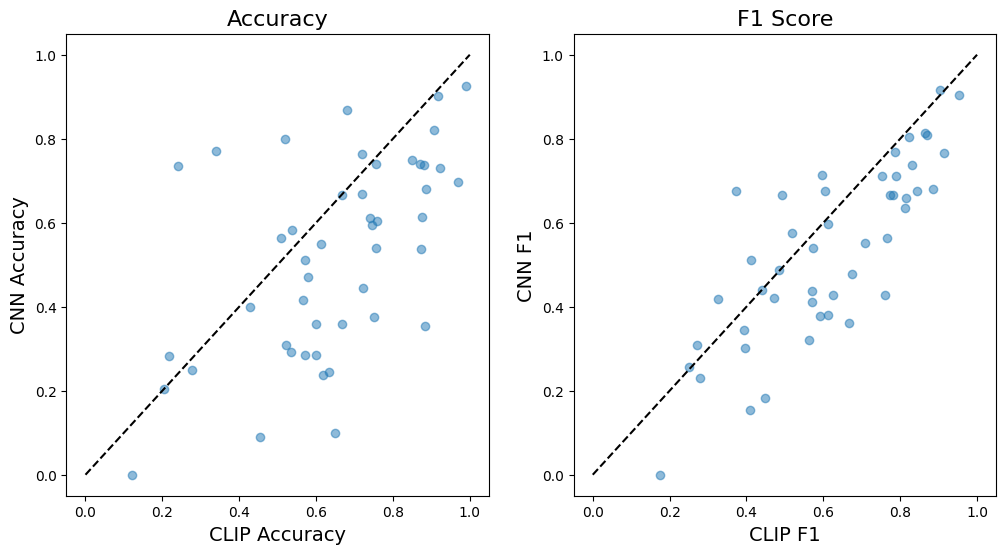

In [17]:
#plt.figure(figsize=(6, 6))
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

axes[0].plot([0, 1], [0, 1], ls='--', color='k')
axes[0].scatter(acc_clip, acc_conv, alpha=.5)

axes[0].set_xlabel("CLIP Accuracy", size=14)
axes[0].set_ylabel("CNN Accuracy", size=14)
#fig.suptitle("CNN vs CLIP", size=18);

axes[1].plot([0, 1], [0, 1], ls='--', color='k')
axes[1].scatter(f1_clip, f1_conv, alpha=.5)


axes[1].set_xlabel("CLIP F1", size=14)
axes[1].set_ylabel("CNN F1", size=14)
axes[0].set_title("Accuracy", size=16)
axes[1].set_title("F1 Score", size=16)
plt.savefig("cnn_v_clip.png", dpi=300)

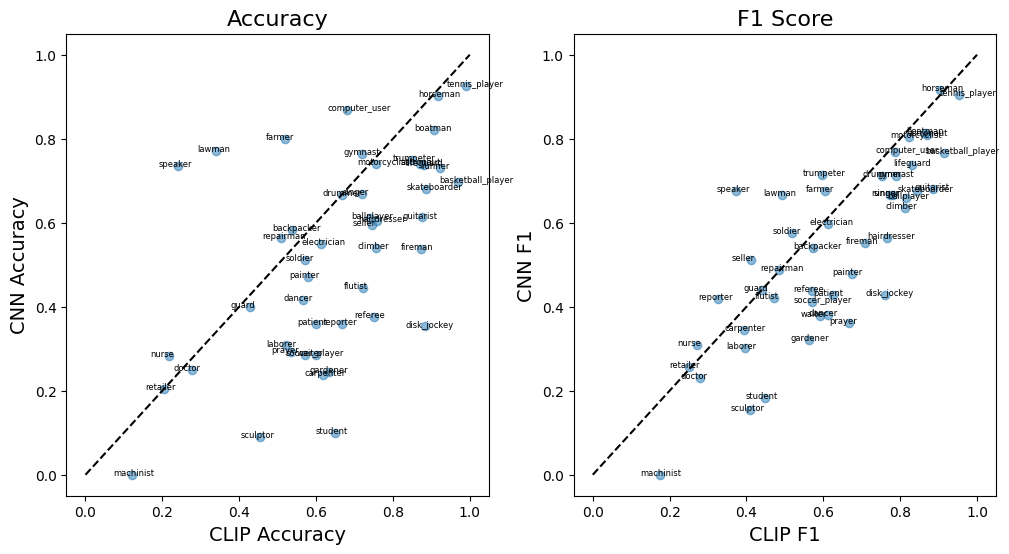

In [18]:
#plt.figure(figsize=(6, 6))
fig, axes = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

axes[0].plot([0, 1], [0, 1], ls='--', color='k')
axes[0].scatter(acc_clip, acc_conv, alpha=.5)

axes[0].set_xlabel("CLIP Accuracy", size=14)
axes[0].set_ylabel("CNN Accuracy", size=14)
#fig.suptitle("CNN vs CLIP", size=18);

axes[1].plot([0, 1], [0, 1], ls='--', color='k')
axes[1].scatter(f1_clip, f1_conv, alpha=.5)

for _x, _y, lab in zip(acc_clip, acc_conv, y_class):
    axes[0].annotate(lab, (_x-.05, _y-.001), size=6)

for _x, _y, lab in zip(f1_clip, f1_conv, y_class):
    axes[1].annotate(lab, (_x-.05, _y-.001), size=6)
    
axes[1].set_xlabel("CLIP F1", size=14)
axes[1].set_ylabel("CNN F1", size=14)
axes[0].set_title("Accuracy", size=16)
axes[1].set_title("F1 Score", size=16)
plt.savefig("cnn_v_clip_labeled.png", dpi=300)

### Plot example classes

In [78]:
from torchvision.transforms import Compose
p = Compose(preprocess.transforms[:2])

def _load_image(filepath, index):
    # Load
    img = Image.open(filepath)
    
    # Bounding box around target
    img = np.array(img)
    bb = df.iloc[index]['bounding_box']
    pad = 200
    j_start, i_start = int(round(bb['x'])), int(round(bb['y']))
    i_end, j_end = i_start + int(bb['height']), j_start + int(bb['width'])
    i_start, j_start = i_start-pad, j_start-pad
    i_end, j_end = i_end+pad, j_end+pad
    j_start = 0 if j_start < 0 else j_start
    i_start = 0 if i_start < 0 else i_start
    img = img[i_start:i_end+1, j_start:j_end+1]
    
    # Preprocess
    img = p(Image.fromarray(img))

    return np.array(img)

In [87]:
c = []
imgs = []
for i in X_train:
    if i[1] not in c:
        c.append(i[1])
        img = _load_image(i[0], int(i[2]))
        imgs.append(img)

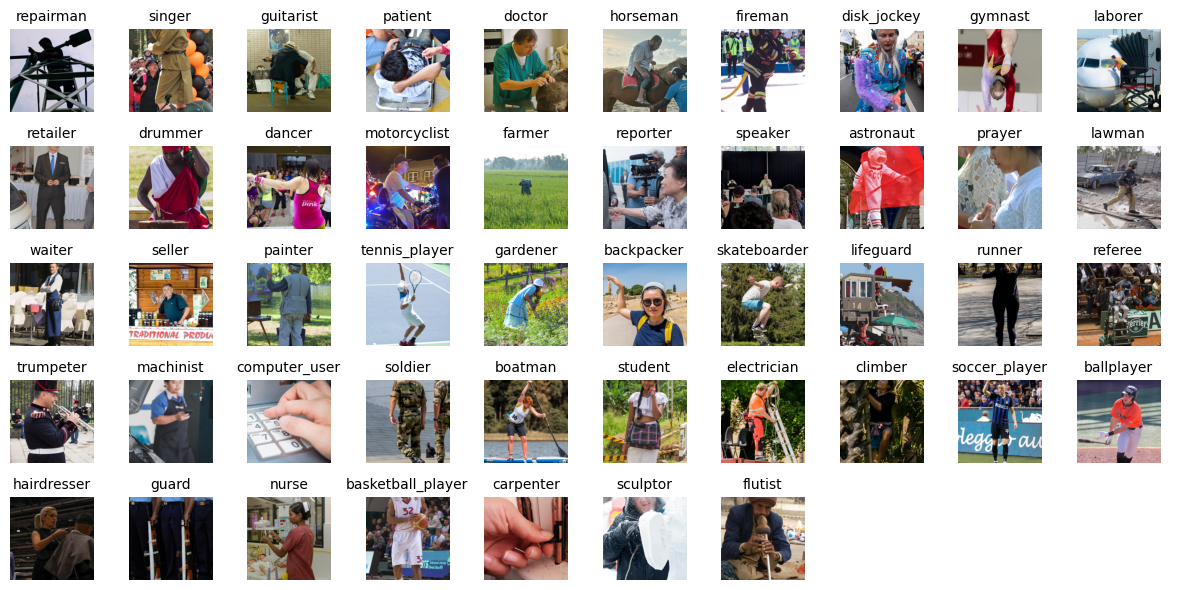

In [114]:
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(12, 6))
axes = axes.flatten()

for i in range(len(imgs)):
    axes[i].imshow(imgs[i])
    axes[i].axis("off")
    axes[i].set_title(c[i], size=10)

for i in range(len(imgs), 50):
    axes[i].axis("off")

plt.tight_layout()

plt.savefig("facet_examples.png", dpi=300)

## CLIP-Dissect

## Last Layer Activations vs True Neuron Labels

In [308]:
_q_k = q_k[-1][:, out_mask].copy()
_P = P.copy()

#_q_k = _q_k - _q_k.mean(axis=0)
P_norm = _P / np.linalg.norm(_P, axis=0)
q_k_norm= _q_k / np.linalg.norm(_q_k, axis=0)

sim = P_norm.T @ q_k_norm

0.7446808510638298
0.7446808510638298


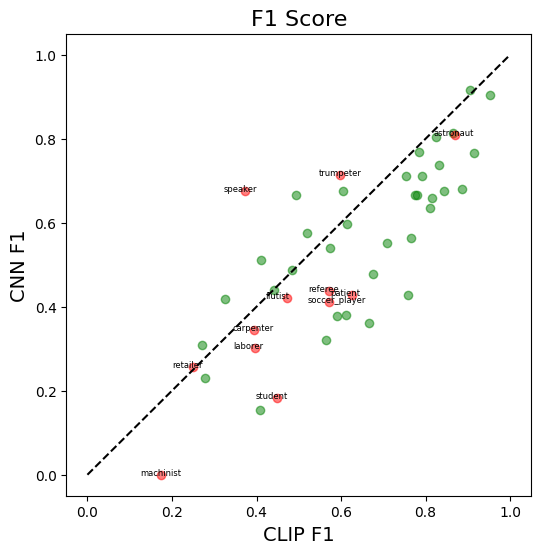

In [310]:
k = 1
inds = np.argsort(sim, axis=1)
inds = inds[:, ::-1][:, :k]

classes_clip_dissect = [[classes_facet[i][j] for j in range(k)]
                         for i in inds]

neuron_labels_correct = []
neuron_labels_incorrect = {}
for i, j in zip(classes_facet, classes_clip_dissect):
   if str(i) == str(j[0]):
       neuron_labels_correct.append(str(i))
   else:
       neuron_labels_incorrect[str(i)] = [str(j[ii]) for ii in range(k)]

print(len(neuron_labels_correct)/(len(neuron_labels_incorrect) + len(neuron_labels_correct)))

#
_neuron_labels_incorrect = []
for k, v in neuron_labels_incorrect.items():
    if k in v:
        neuron_labels_correct.append(k)
    else:
        _neuron_labels_incorrect.append(k) 

print(len(neuron_labels_correct)/(len(neuron_labels_incorrect) + len(neuron_labels_correct)))


inds_correct = np.array(
    [i for i in range(len(y_class)) if y_class[i] in neuron_labels_correct]
)

inds_incorrect = np.array(
    [i for i in range(len(y_class)) if y_class[i] not in neuron_labels_correct]
)

# plt.figure(figsize=(6, 6))
fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)

ax.plot([0, 1], [0, 1], ls='--', color='k')
ax.scatter(np.array(f1_clip)[inds_correct], np.array(f1_conv)[inds_correct], alpha=.5, color='green')
ax.scatter(np.array(f1_clip)[inds_incorrect], np.array(f1_conv)[inds_incorrect], alpha=.5, color='red')

ax.set_xlabel("CLIP F1", size=14)
ax.set_ylabel("CNN F1", size=14)
ax.set_title("F1 Score", size=16)


i = 0
for _x, _y, lab in zip(f1_clip, f1_conv, y_class):
    if i in inds_incorrect:
        ax.annotate(lab, (_x-.05, _y-.001), size=6)
    i += 1  

plt.savefig('last_layer.png', dpi=300);

## Similarity with Sensitive Terms

In [758]:
# Sensitive terms
sensitive_terms = [
    'light skin', 'dark skin', # skin
    'masculine', 'feminine', # gender
    'young', 'old' # age
]

# Concepts
_concept_terms = [str(i) if "_" not in i else i.replace("_", " ")
                 for i in classes_facet]

# Combine
concept_terms = []
for i in _concept_terms:
    concept_terms.append(str(i))
    for j in sensitive_terms:
        concept_terms.append(str(j) + " " + str(i))

# Tokenize
concepts = clip.tokenize(concept_terms).to("mps")

In [759]:
# Drop rows that lack sensitive variables
sens_mask = (
    (df_test["gender_presentation_na"] == 0) &
    (df_test["age_presentation_na"] == 0) &
    (df_test["skin_tone_na"] == 0)
)

sens_mask = np.array(sens_mask)
for i in np.where(df_test[['skin_tone_' + str(i) for i in range(1, 11)]].sum(axis=1) == 0)[0]:
   sens_mask[i] = False

In [760]:
# Compute P and q_k for clip-dissect
P_sens = np.zeros((len(X_test[sens_mask]), len(concepts)))

n_channels = [16, 16, 24, 24, 40, 40, 40, 80, 80, 80,
              80, 112, 112, 160, 160, 160, 960, 1, 11221]
q_k_sens = [
    np.zeros((len(X_test[sens_mask]), i)) for i in n_channels
]   

# Evaluate test set
y_test_pred_clip_sens = np.zeros(len(X_test[sens_mask]))

batch_size = 20

for row in tqdm(range(0, len(X_test[sens_mask]), batch_size), total=len(X_test[sens_mask])//batch_size):

    # Load data
    xt = X_test[sens_mask][row:row+batch_size]
    x = torch.zeros((len(xt), 3, 224, 224), dtype=torch.float32)
    y = torch.zeros(len(xt), dtype=torch.int64)
    for j in range(len(xt)):
        x[j] = load_image(xt[j][0], int(xt[j][2]))
        y[j] = class_lookup[xt[j][1]]
    y_test_true[row:row+len(xt)] = y.numpy()
    x = x.to('mps')
    y = y.to('mps')
    
    # Forward
    activation = {}
    y_pred = model(x)
    
    # 1. Compute P
    with torch.no_grad():
        logits_per_image, logits_per_text = clip_model(x, concepts)
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    y_test_pred_clip_sens[row:row+len(xt)] = np.argmax(probs, axis=1)
    P_sens[row:row+len(xt)] = probs
    
    # 2. Compute activations, q_k)
    for i, k in enumerate(activation.keys()):
        # Activations per convolutional channel
        if k == "conv_head":
            # Last convolutional layer gets flatten
            q_k_sens[i][row] = activation[k].cpu().numpy()[0].mean()
        elif k == 'classifier':
            q_k_sens[i][row] = activation[k].cpu().numpy()[0]
        else:
            q_k_sens[i][row] = activation[k].cpu().numpy()[0].mean(axis=(1, 2))


# Save results
np.save("y_test_pred_clip_sens", y_test_pred_clip_sens)
np.save("P_terms-classes_sens.npy", P_sens)
for i in range(len(q_k_sens)):
    np.save(f"qk_terms-classes_activation-{i}_sens.npy", q_k_sens[i])

  0%|          | 0/91 [00:00<?, ?it/s]

In [761]:
# y_test_pred_clip_sens = np.load("y_test_pred_clip_sens.npy")
# P_sens = np.load("P_terms-classes_sens.npy")
# q_k_sens = []
# for i in range(19):
#     q_k_sens.append(np.load(f"qk_terms-classes_activation-{i}_sens.npy"))

In [762]:
# Cosine similarity
_q_k = q_k_sens[-1][:, out_mask].copy()
_P = P_sens.copy()

P_norm = _P / np.linalg.norm(_P, axis=0)
q_k_norm= _q_k / np.linalg.norm(_q_k, axis=0)

sim = P_norm.T @ q_k_norm

In [763]:
inds = np.argmax(sim, axis=0)
#inds = inds[:, ::-1][:, :k]

classes_clip_dissect = [concept_terms[i] for i in inds]

# fig, ax = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)

# ax.plot([0, 1], [0, 1], ls='--', color='k')
# ax.scatter(np.array(f1_clip)[inds_correct], np.array(f1_conv)[inds_correct], alpha=.5, color='green')
# ax.scatter(np.array(f1_clip)[inds_incorrect], np.array(f1_conv)[inds_incorrect], alpha=.5, color='red')

# ax.set_xlabel("CLIP F1", size=14)
# ax.set_ylabel("CNN F1", size=14)
# ax.set_title("F1 Score", size=16)


# i = 0
# for _x, _y, lab in zip(f1_clip, f1_conv, y_class):
#     if i in inds_incorrect:
#         ax.annotate(lab, (_x-.05, _y-.001), size=6)
#     i += 1  

#plt.savefig('last_layer.png', dpi=300);

In [782]:
c = 0
for i, j in zip(np.array(classes_clip_dissect), classes_facet):
    n = (df_test.iloc[sens_mask]['class1'] == j).sum()
    if j in i.replace(" ", "_"):
        print(i, "->", j, str(n))
        c += 1
c / 48

masculine boatman -> boatman 49
young climber -> climber 9
computer user -> computer_user 53
masculine dancer -> dancer 33
farmer -> farmer 61
feminine fireman -> fireman 8
light skin guard -> guard 44
gymnast -> gymnast 48
young hairdresser -> hairdresser 39
young lifeguard -> lifeguard 18
feminine nurse -> nurse 21
young painter -> painter 58
dark skin referee -> referee 20
light skin runner -> runner 19
seller -> seller 62
light skin singer -> singer 74
masculine tennis player -> tennis_player 174
trumpeter -> trumpeter 11


0.375

masculine tennis player -> tennis_player 174
masculine boatman -> boatman 49

young painter -> painter 58
young hairdresser -> hairdresser 39

light skin singer -> singer 74
light skin guard -> guard 44

In [785]:
_class = 'tennis_player'
mask = df_test[sens_mask]['class1'] == _class
(df_test[sens_mask][mask]["gender_presentation_fem"].sum(),
 df_test[sens_mask][mask]["gender_presentation_masc"].sum())

(np.int64(72), np.int64(102))

In [786]:
_class = 'boatman'
mask = df_test[sens_mask]['class1'] == _class
(df_test[sens_mask][mask]["gender_presentation_fem"].sum(),
 df_test[sens_mask][mask]["gender_presentation_masc"].sum())

(np.int64(22), np.int64(27))

In [788]:
_class = 'painter'
mask = df_test[sens_mask]['class1'] == _class
(df_test[sens_mask][mask]["age_presentation_older"].sum(),
 df_test[sens_mask][mask]["age_presentation_young"].sum())

(np.int64(13), np.int64(19))

In [789]:
_class = 'hairdresser'
mask = df_test[sens_mask]['class1'] == _class
(df_test[sens_mask][mask]["age_presentation_older"].sum(),
 df_test[sens_mask][mask]["age_presentation_young"].sum())

(np.int64(4), np.int64(5))

In [790]:
df_skin = df_test[sens_mask][[
    i for i in df_test.columns
    if ("skin" in i and "na" not in i) or 'class1' in i
]]

classes = df_skin.pop("class1")

s =  np.array(df_skin)
smask = (s.sum(axis=1) != 0)
df_skin = df_skin[smask]

skin =  np.array(df_skin)
skin = (skin * np.arange(1, 11)).sum(axis=1) / skin.sum(axis=1)

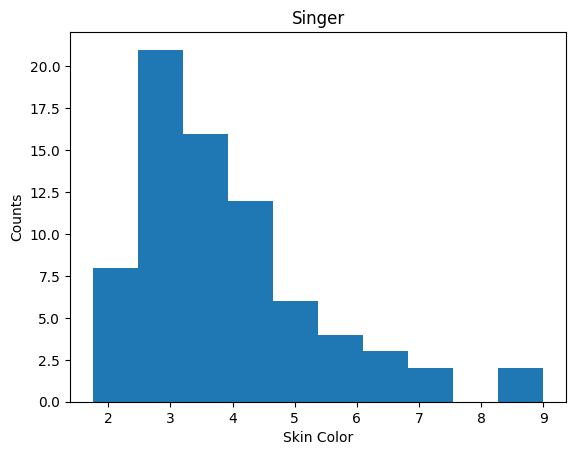

In [798]:
_class = 'singer'
cmask = classes == _class
cmask = cmask[smask]
skin[cmask].mean()
plt.hist(skin[cmask])
plt.title("Singer")
plt.ylabel("Counts")
plt.xlabel("Skin Color")
plt.savefig("singer_skin_counts.png", dpi=300)

In [801]:
X_test[sens_mask].shape

(1832, 3)

In [799]:
P_sens.shape

(1832, 329)

In [815]:
classes = X_test[sens_mask][:, 1]

In [812]:
terms = np.array(concept_terms)
terms_pred = terms[np.argmax(P_sens, axis=1)]

In [849]:
classes[i], terms_pred[i].replace(" ", "_")

(np.str_('speaker'), 'old_reporter')

502 hairdresser old hairdresser
529 soldier dark skin soldier
540 carpenter old carpenter
566 guitarist old guitarist
581 painter old painter
588 guitarist old guitarist
619 gardener old gardener
660 soldier feminine soldier
666 lifeguard old lifeguard
682 trumpeter old trumpeter
689 guitarist old guitarist
720 painter old painter
721 flutist old flutist
732 gardener old gardener
757 carpenter old carpenter
762 guitarist old guitarist
770 lifeguard old lifeguard
773 seller old seller
784 disk_jockey old disk jockey
813 drummer old drummer
854 painter old painter
901 gymnast old gymnast
945 soldier masculine soldier
949 hairdresser old hairdresser
966 guitarist old guitarist


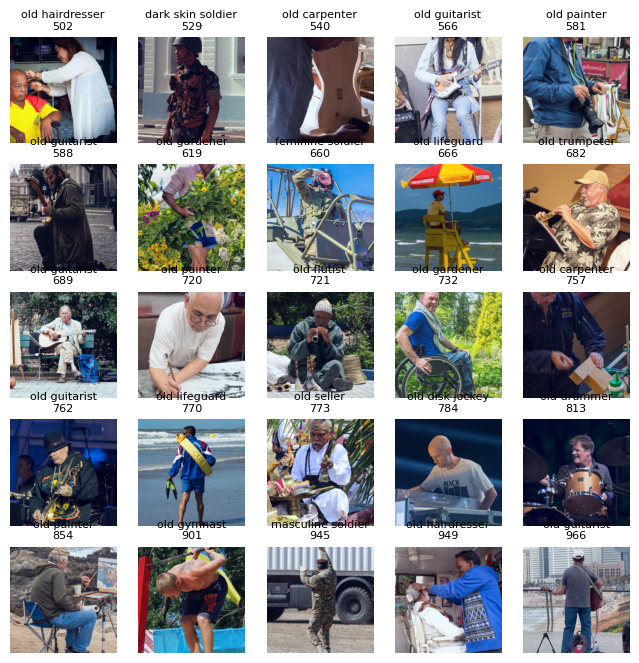

In [883]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8))
axes = axes.flatten()

j = 0
for i in range(500, len(P_sens)):
    
    ca = classes[i] in terms_pred[i].replace(" ", "_")
    cb = len(terms_pred[i].replace(" ", "_")) > len(classes[i])
    #cd = "skin" in terms_pred[i]

    cd = "old" in terms_pred[i]
    
    if  ca and cb and cd:
        print(i, classes[i], terms_pred[i])
        im = load_image(X_test[sens_mask][i][0], int(X_test[sens_mask][i][2]))
        im = im.numpy().T.swapaxes(0, 1)
        imn = (im-im.min())/im.max()
        imn = imn/imn.max()
        axes[j].imshow(imn)
        axes[j].set_title(terms_pred[i] + "\n" + str(i), size=8)
        axes[j].axis("off")
        j+=1


    
    if j == 25:
        break
        

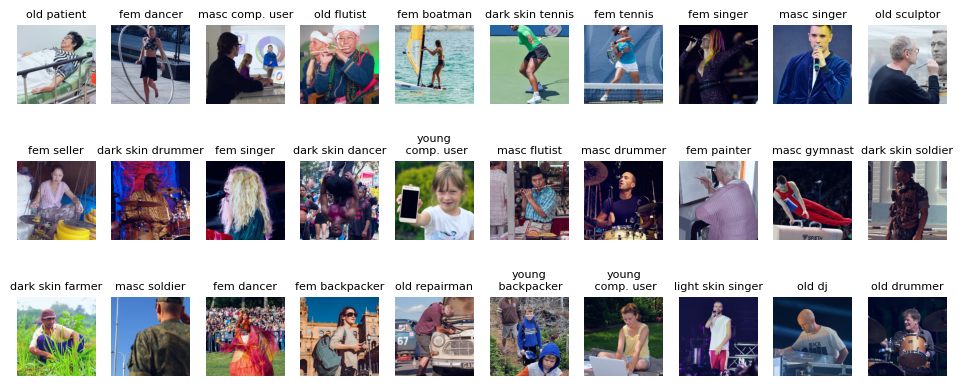

In [896]:
fig, axes = plt.subplots(nrows=3, ncols=10, figsize=(12, 5))
axes = axes.flatten()

inds = [
    7, 8, 11, 15, 21,
    25, 57, 61, 62, 113,
    119, 465, 152, 154, 156, 
    166, 167, 185, 193, 529,
    525, 205, 206, 219, 262,
    308, 610, 780, 784, 813
]

j = 0
for i in range(len(inds)):

    im = load_image(X_test[sens_mask][inds[i]][0], int(X_test[sens_mask][inds[i]][2]))
    im = im.numpy().T.swapaxes(0, 1)
    imn = (im-im.min())/im.max()
    imn = imn/imn.max()
    axes[j].imshow(imn)
    title = terms_pred[inds[i]]
    title = title.replace("feminine", "fem")
    title = title.replace("masculine", "masc")
    title = title.replace("tennis player", "tennis")
    title = title.replace("computer user", "comp. user")
    title = title.replace("young", "young\n")
    title = title.replace("disk jockey", "dj")
    axes[j].set_title(title, size=8)
    axes[j].axis("off")
    j+=1

#plt.tight_layout()
plt.savefig("clip_zero_shot.png", dpi=300)

In [897]:
(2 * np.sqrt(8))**2


np.float64(32.00000000000001)

In [898]:
np.log(6)

np.float64(1.791759469228055)